In [1]:
from os import listdir
from os.path import join

import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
%matplotlib inline
set_matplotlib_formats('svg')

from parse_midi import Midi
from parse_midi import MessageType
import parse_midi

In [2]:
midi_dir = './midi_files'
midi_paths = [join(midi_dir, x) for x in listdir(midi_dir)]
midi_paths[:5]

['./midi_files/mz_545_3.mid',
 './midi_files/mz_333_2.mid',
 './midi_files/mz_332_1.mid',
 './midi_files/mz_545_1.mid',
 './midi_files/mz_311_1.mid']

In [3]:
fp = midi_paths[1]
print(fp)
m = Midi.from_file(fp)

./midi_files/mz_333_2.mid


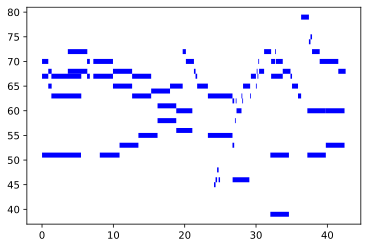

In [11]:

# note_times should be a list of time ranges and dictionaries with Note & Velocity

def plot_piano_roll(note_times):

    for nt in note_times: 
        plt.plot(list(nt[1]), [nt[0].data[0], nt[0].data[0]], lw=5, solid_capstyle='butt', color='blue')


    return plt.show()

plot_piano_roll(m.get_events_in_timerange(0, 50).note_times())


In [5]:

# dtimes = []
# for evt, _ in note_times:
#     dtimes.append(evt.dtime)
    

x = 13 * 0.0015


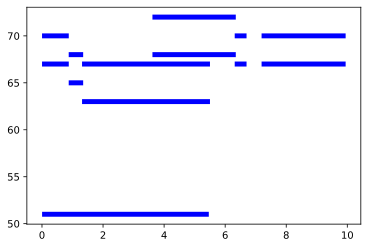

In [9]:


plot_piano_roll(m.get_events_in_timerange(0, 10).note_times())
# i = 0

# words = []
# while i < 10:
#     words.append(get_notes_in_timerange(m.note_times(), (i, i + x)))
#     i += x
    
# for word in words:
#     if len(word) > 0:
#         plot_piano_roll(word)
#         plt.show()

> In order to study the extend to which word2vec can model musical context, polyphonic musical
pieces are represented with as little injected musical knowledge as possible. Each piece is simply
segmented into equal-length, non-overlapping slices. The duration of these slices is calculated
for each piece based on the distribution of time between note onsets. The smallest amount of
time between consecutive onsets that occurs in more than 5% of all cases is selected as the
slice-size. The slices capture all pitches that sound in a slice: those that have their onset in the
slice, and those that are played and held over the slice. The slicing process does not depend
on musical concepts such as beat or time signature; instead, it is completely data-driven. Our
vocabulary of words, will thus consist of a collection of musical slices.
In addition, we do not label pitches as chords...